Обучить сиамскую сеть для верификации лиц на датасете LFW

Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [0]:
print(tf.__version__)

2.2.0


In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

In [0]:
train_ds

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

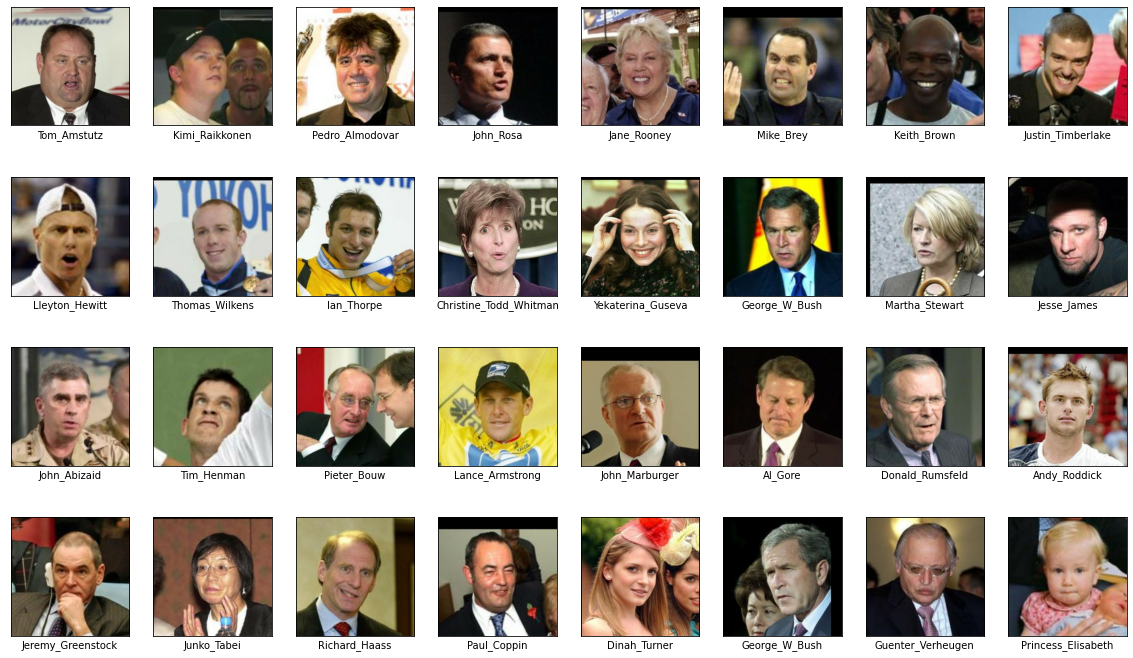

In [0]:
some_samples = [x for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(20, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][1])
    ax.set_xlabel(some_samples[j][0].numpy().decode())
    plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
INP_SIZE = 250
NUM_EPOCHS = 10
BATCH_SIZE = 64

def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return label, tf.image.resize(img, [INP_SIZE, INP_SIZE])

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [0]:
MARGIN = 100.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [0]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 9772.27734375
[200] Loss: 1.2534219026565552
[400] Loss: 17.60298728942871
[600] Loss: 96.63431549072266
[800] Loss: 0.0
[1000] Loss: 0.0
[1200] Loss: 31.260162353515625
[1400] Loss: 16.943927764892578
[1600] Loss: 0.0
[1800] Loss: 50.166465759277344
[2000] Loss: 0.9682111144065857
CPU times: user 9min 18s, sys: 4min 43s, total: 14min 1s
Wall time: 16min 59s


In [0]:
import imageio
from skimage.transform import resize

In [0]:
def load_and_prepare_image(fpath):
    
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = resize(img, (INP_SIZE, INP_SIZE, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (INP_SIZE, INP_SIZE, 3))
    return img

In [0]:
gw_bush_1 = load_and_prepare_image('George-W-Bush.jpeg')
gw_bush_2 = load_and_prepare_image('GW-Bush-in-uniform.jpg')
gh_bush = load_and_prepare_image('George_H._W._Bush.jpg')
trump = load_and_prepare_image('Donald_Trump.jpg')
obama = load_and_prepare_image('Barack_Obama.jpg')

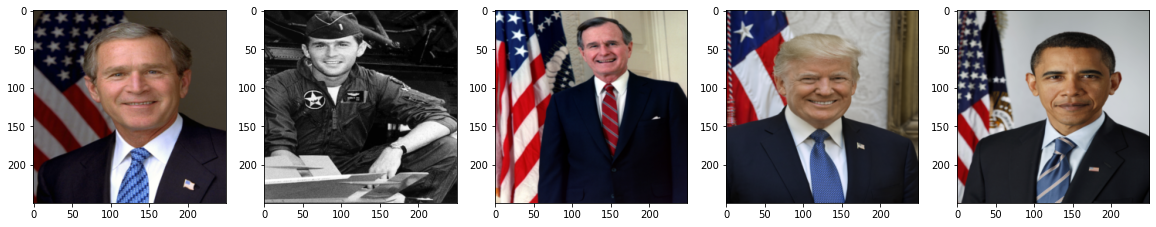

In [0]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(gw_bush_1)
ax = fig.add_subplot(1, 5, 2)
ax.imshow(gw_bush_2)
ax = fig.add_subplot(1, 5, 3)
ax.imshow(gh_bush)
ax = fig.add_subplot(1, 5, 4)
ax.imshow(trump)
ax = fig.add_subplot(1, 5, 5)
ax.imshow(obama)
plt.show()

In [0]:
new_embs = model(np.stack((gw_bush_1, gw_bush_2, gh_bush, trump, obama), axis=0))

In [0]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [0]:
emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4   = new_embs[3,:]
emb5   = new_embs[4,:]

In [0]:
print('George W Bush 1 <-> George W Bush 2: ', diff(emb1, emb2))
print('George W Bush 2 <-> George H Bush: ', diff(emb2, emb3))
print('George W Bush 1 <-> George H Bush: ', diff(emb1, emb3))
print('George W Bush 1 <-> Donald Trump: ', diff(emb1, emb4))
print('Barack Obama <-> Donald Trump: ', diff(emb5, emb4))


George W Bush 1 <-> George W Bush 2:  141.3470214357204
George W Bush 2 <-> George H Bush:  288.6791309135456
George W Bush 1 <-> George H Bush:  200.04427244362685
George W Bush 1 <-> Donald Trump:  100.47893124929226
Barack Obama <-> Donald Trump:  70.07532219868847


Самое большее между собой похожи Трамп и Обама (чтобы там Трамп не говорил). Трамп на Джорджа Буша тоже похож, а тот в свою очередь не особо похож на себя молодого, а на отца совсем не похож.